In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [102]:
df=pd.read_csv("AAPL_5Y.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-21,26.732500,26.732500,26.379999,26.4925,24.640911,126210000
1,2016-04-22,26.252501,26.620001,26.155001,26.4200,24.573479,134732400
2,2016-04-25,26.250000,26.412500,26.127501,26.2700,24.433960,112126400
3,2016-04-26,25.977501,26.325001,25.977501,26.0875,24.264212,224064800
4,2016-04-27,24.000000,24.677500,23.920000,24.4550,22.745811,458408400


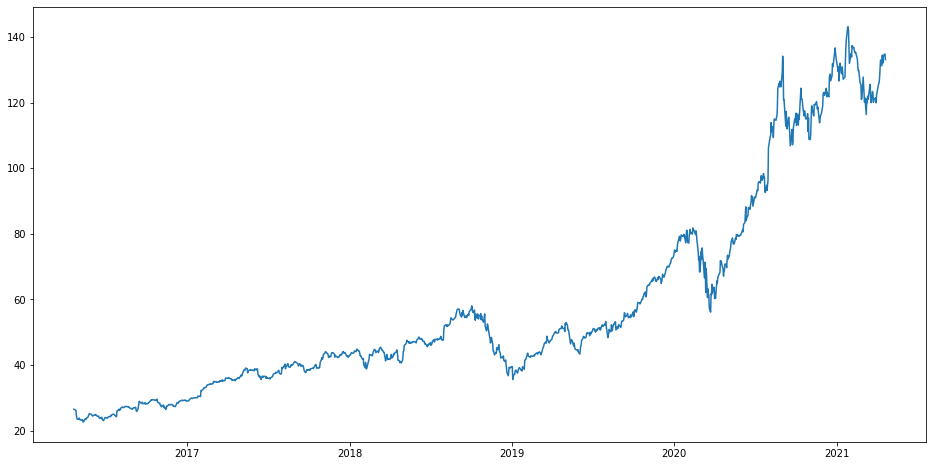

In [103]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [179]:
days_watching = 200

In [180]:
data = df.sort_index(ascending=True,axis=0)
df_new = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df_new["Date"][i] = data['Date'][i]
    df_new["Close"][i] = data["Close"][i]
    
# print(df_new.head())
df_new.index = df_new.Date
df_new.drop("Date", axis=1, inplace=True)

final_dataset = df_new.values

train_data = final_dataset[0:1000,:]
valid_data = final_dataset[1000:,:]
# print(train_data[-10:])
# print()
# print(valid_data[-10:])

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(days_watching,len(train_data)):
    x_train_data.append(scaled_data[i-days_watching:i,0])
    y_train_data.append(scaled_data[i,0])
# print(x_train_data[0])
# print()
# print(y_train_data[0])
# print(x_train_data[1])
# print()
# print(y_train_data[1])
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [183]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=75,return_sequences=False,input_shape=(x_train_data.shape[1],1)))
# lstm_model.add(LSTM(units=30, return_sequences=True))
# lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=3,batch_size=1,verbose=2)

Epoch 1/3
800/800 - 11s - loss: 6.0112e-04
Epoch 2/3
800/800 - 10s - loss: 2.3191e-04
Epoch 3/3
800/800 - 10s - loss: 2.0600e-04


<ipython-input-184-c87333540add>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = close_predict


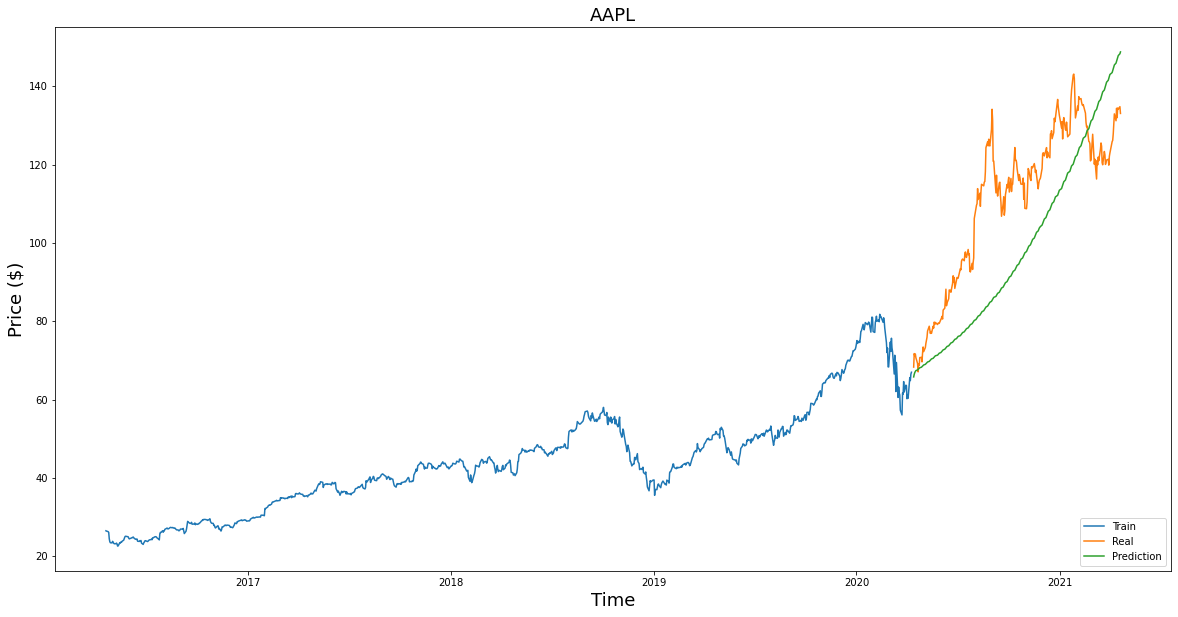

In [184]:
inputs_data = df_new[len(df_new)-len(valid_data)-days_watching:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

# print("days in test", inputs_data.shape[0])
base_q = []
base_q.append(inputs_data[0:days_watching,0])
# print(base_q)
# print(base_q[0])
close_predict = []

for i in range(days_watching,inputs_data.shape[0]):
# for i in range(days_watching,days_watching+10):
# TODO: optimize
    X_test = base_q.copy()
    X_test = np.array(X_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    closing_price = lstm_model.predict(X_test)
    base_q[0] = np.delete(base_q[0],0)
    base_q[0] = np.append(base_q[0],closing_price)
    closing_price = scaler.inverse_transform(closing_price)
#     (base_q[0]).append(closing_price)
#     print(base_q)
#     print(closing_price)
    close_predict.append(closing_price)
#     X_test.append(base_q[0:days_watching])
# X_test = []
# X_test.append(inputs_data[0:days_watching,0])
# for i in range(days_watching,inputs_data.shape[0]):
#     X_test.append(inputs_data[i-days_watching:i,0])



# X_test = np.array(X_test)

# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# closing_price = lstm_model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)
# print(X_test, "\n", closing_price)


train_data = df_new[:1000]
valid_data = df_new[1000:]
valid_data['Predictions'] = close_predict
plt.title('AAPL', fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Price ($)',fontsize=18)
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
plt.legend(['Train', 'Real', 'Prediction' ], loc='lower right')

lstm_model.save("saved_lstm_model.h5")
# model = keras.models.load_model('path/to/location')